In [0]:
import zipfile
import os
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model, load_model
from keras.layers.core import Dense, Dropout, Activation,Flatten
from tensorflow.keras.layers import Input, concatenate, Dense, Flatten, Activation, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LambdaCallback
from keras import optimizers
from keras.utils import np_utils
%matplotlib inline

from google.colab import drive, files
drive.mount('/content/gdrive',force_remount=True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Using TensorFlow backend.


## Unzipping the file with the images

In [0]:
with zipfile.ZipFile('/content/gdrive/My Drive/Big Data/Projet/celeba-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/img/')

# Resize images

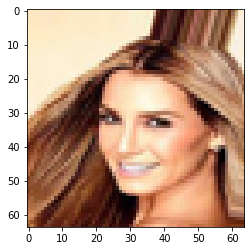

In [0]:
image = Image.open('/content/img/img_align_celeba/img_align_celeba/000001.jpg')
new_image = image.resize((64, 64))
plt.imshow(new_image)

# Création de la base de données

In [0]:
samp = pickle.load(open('/content/gdrive/My Drive/Big Data/Projet/Listes sample/Wavy_Hair.pkl', 'rb'))

In [0]:
path = '/content/img/img_align_celeba/img_align_celeba/'
target = []
data = np.zeros((len(samp), 64, 64, 3)) #dimension of the images
count = 0
for file in os.listdir(path) :
  if file in samp :
    image = Image.open(path + file)
    image = image.resize((64, 64))
    data[count] = np.array(image)
    target.append(file)
    if count%1000 == 0 :
      print(count)
    count += 1

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000


In [0]:
all_attributes = pd.read_csv('/content/img/list_attr_celeba.csv')
wavy = all_attributes[['image_id','Wavy_Hair']]
wavy = wavy.loc[wavy[wavy['image_id'].isin(target) == True].index]
wavy = wavy.set_index('image_id')
wavy = wavy.loc[target]
wavy.head()

,Wavy_Hair
image_id,
158236.jpg,-1
081073.jpg,1
107955.jpg,1
060717.jpg,1
145210.jpg,1


In [0]:
len(wavy)

20000

In [0]:
data.shape

(20000, 64, 64, 3)

# Creation of the train and test sets

In [0]:
target = np.array(wavy.Wavy_Hair)
target[target == -1] = 0

In [0]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2)

In [0]:
print(X_train.shape, y_train.shape)

(16000, 64, 64, 3) (16000,)


In [0]:
np.array(wavy.Wavy_Hair)[1:100].shape

(99,)

In [0]:
y_train.shape

(16000,)

# Creation of the NN

In [0]:
conv_net = Sequential()

# convolution layer 1
conv_net.add(Conv2D(64, (3, 3), activation = 'relu', input_shape = (64, 64, 3)))
conv_net.add(MaxPooling2D(pool_size = (2, 2)))
conv_net.add(Dropout(0.5))

print(conv_net.output.shape)

# convolution layer 2
conv_net.add(Conv2D(128, (3, 3), activation = 'relu'))
conv_net.add(MaxPooling2D(pool_size = (2, 2)))
conv_net.add(Dropout(0.5))

# convolution layer 3
conv_net.add(Conv2D(256, (3, 3), activation = 'relu'))
conv_net.add(MaxPooling2D(pool_size = (2, 2)))
conv_net.add(Dropout(0.5))

# convolution layer 3
conv_net.add(Conv2D(512, (3, 3), activation = 'relu'))
conv_net.add(MaxPooling2D(pool_size = (2, 2)))
conv_net.add(Dropout(0.5))

print(conv_net.output.shape)

# fully connected
conv_net.add(Flatten())
conv_net.add(Dense(2048, activation = 'relu'))
conv_net.add(Dropout(0.3))
conv_net.add(Dense(1024, activation = 'relu'))
conv_net.add(Dropout(0.3))
conv_net.add(Dense(512, activation = 'relu'))
conv_net.add(Dropout(0.4))
conv_net.add(Dense(128, activation = 'relu'))
conv_net.add(Dropout(0.5))
conv_net.add(Dense(1, activation = 'sigmoid'))

conv_net.compile(loss = 'binary_crossentropy', optimizer = 'adam', 
                 metrics = ['accuracy'])

(None, 31, 31, 64)
(None, 2, 2, 512)


## callbacks to save the best model

In [0]:
reduce_lr = ReduceLROnPlateau(monitor = 'loss', factor = 0.2,
                              patience = 1, min_lr = 0.001)

# Path where we will save our model
filepath = "/content/gdrive/My Drive/Big Data/models/Wavy_Hair.hdf5" 
checkpoint = ModelCheckpoint(filepath, monitor = 'val_accuracy',
                             verbose = 1, save_best_only = True,
                             mode = 'max')
callbacks = [checkpoint, reduce_lr]

In [0]:
conv_net.fit(X_train, y_train, batch_size = 256, epochs = 50, 
             validation_data = (X_test, y_test), callbacks = callbacks)

Epoch 1/50
63/63 [==============================] - ETA: 0s - loss: 5.5521 - accuracy: 0.5043
Epoch 00001: val_accuracy improved from -inf to 0.51325, saving model to /content/gdrive/My Drive/Big Data/models/Wavy_Hair.hdf5
63/63 [==============================] - 5s 81ms/step - loss: 5.5521 - accuracy: 0.5043 - val_loss: 0.6930 - val_accuracy: 0.5132 - lr: 0.0010
Epoch 2/50
63/63 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.5031
Epoch 00002: val_accuracy did not improve from 0.51325
63/63 [==============================] - 3s 48ms/step - loss: 0.6933 - accuracy: 0.5031 - val_loss: 0.6930 - val_accuracy: 0.5132 - lr: 0.0010
Epoch 3/50
63/63 [==============================] - ETA: 0s - loss: 0.6928 - accuracy: 0.5056
Epoch 00003: val_accuracy did not improve from 0.51325
63/63 [==============================] - 3s 49ms/step - loss: 0.6928 - accuracy: 0.5056 - val_loss: 0.6929 - val_accuracy: 0.5132 - lr: 0.0010
Epoch 4/50
63/63 [==============================] 